# ........................................................***HACKATONE***...........................................................................

In [2]:
!pip install selenium



In [2]:
!pip install webdriver_manager

In [3]:
import os
import time
import random
import pandas as pd
from tqdm import tqdm

from selenium import webdriver
from selenium.common.exceptions import WebDriverException
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager


# ---------------- CONFIG ----------------
CATEGORIES = {
    "phones": "https://www.banggood.com/search/phones.html?page={}",
    "smartwatches": "https://www.banggood.com/search/smartwatches.html?page={}",
    "laptops": "https://www.banggood.com/search/laptops.html?page={}",
    "rc_drones": "https://www.banggood.com/search/rc-drones.html?page={}",
    "home_appliances": "https://www.banggood.com/search/home-appliances.html?page={}"
}

OUTPUT_DIR = "data/raw"
os.makedirs(OUTPUT_DIR, exist_ok=True)

MAX_PAGES = 5
RETRY_LIMIT = 5      # 🔥 NEW FIX


# ---------------- DRIVER ----------------
def get_driver():
    options = Options()

    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--disable-blink-features=AutomationControlled")
    options.add_argument("window-size=1920,1080")

    # 🔥 Best working user-agent for Banggood
    options.add_argument(
        "user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128 Safari/537.36"
    )

    driver = webdriver.Chrome(
        service=Service(ChromeDriverManager().install()),
        options=options
    )

    driver.set_page_load_timeout(60)    # 🔥 very important
    return driver


# -------------- SAFE PAGE LOADER ----------------
def safe_get(driver, url):
    for attempt in range(RETRY_LIMIT):
        try:
            driver.get(url)
            return True
        except WebDriverException:
            print(f"⚠ DNS failed → Retrying ({attempt+1}/{RETRY_LIMIT}) ...")
            time.sleep(3)

    print(f"❌ FAILED to load page after {RETRY_LIMIT} retries: {url}")
    return False


# ---------------- SCRAPER ----------------
def scrape_category(category_name, url_template):
    driver = get_driver()
    all_products = []

    print(f"\n🔵 Scraping: {category_name}")

    for page in tqdm(range(1, MAX_PAGES + 1), desc=f"{category_name} pages"):

        # Page URL
        url = url_template.format(page)

        # Retry loader
        if not safe_get(driver, url):
            continue

        time.sleep(4)

        # Scroll full page
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)

        items = driver.find_elements(By.CSS_SELECTOR, "div.p-wrap")

        # If blocked or no items → retry same page
        if len(items) == 0:
            print(f"⚠ No items found on page {page}, retrying...")
            time.sleep(3)
            if not safe_get(driver, url):
                continue
            items = driver.find_elements(By.CSS_SELECTOR, "div.p-wrap")

        # Still no items? then stop category.
        if len(items) == 0:
            print("⚠ Skipping category — selectors not found.")
            break

        # Extract data
        for item in items:
            try:
                title_elem = item.find_element(By.CSS_SELECTOR, "a.title")
                name = title_elem.text.strip()
                product_url = title_elem.get_attribute("href")
            except:
                name = None
                product_url = None

            try:
                price = item.find_element(By.CSS_SELECTOR, "span.price").text.strip()
            except:
                price = None

            try:
                old_price = item.find_element(By.CSS_SELECTOR, "span.price-old").text.strip()
            except:
                old_price = None

            try:
                discount = item.find_element(By.CSS_SELECTOR, "span.price-discount").text.strip()
            except:
                discount = None

            try:
                reviews = item.find_element(By.CSS_SELECTOR, "a.review").text.strip()
            except:
                reviews = None

            try:
                rating = item.find_element(By.CSS_SELECTOR, "span.review-text").text.strip()
            except:
                rating = None

            all_products.append({
                "category": category_name,
                "product_name": name,
                "product_url": product_url,
                "price": price,
                "old_price": old_price,
                "discount": discount,
                "reviews": reviews,
                "rating": rating
            })

        time.sleep(random.uniform(2, 4))

    driver.quit()

    # Save CSV
    df = pd.DataFrame(all_products)
    output_file = os.path.join(OUTPUT_DIR, f"{category_name}.csv")
    df.to_csv(output_file, index=False)

    print(f"✅ Saved {len(all_products)} products → {output_file}")


# ---------------- MAIN ----------------
def main():
    for category, url in CATEGORIES.items():
        scrape_category(category, url)


if __name__ == "__main__":
    main()



🔵 Scraping: phones


phones pages: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.02s/it]


✅ Saved 300 products → data/raw\phones.csv

🔵 Scraping: smartwatches


smartwatches pages:  20%|████████████▊                                                   | 1/5 [00:23<01:34, 23.64s/it]

⚠ No items found on page 2, retrying...


smartwatches pages:  20%|████████████▊                                                   | 1/5 [00:39<02:37, 39.46s/it]

⚠ Skipping category — selectors not found.


✅ Saved 29 products → data/raw\smartwatches.csv

🔵 Scraping: laptops


laptops pages:  80%|███████████████████████████████████████████████████████▏             | 4/5 [01:49<00:25, 25.99s/it]

⚠ No items found on page 5, retrying...


laptops pages:  80%|███████████████████████████████████████████████████████▏             | 4/5 [02:03<00:30, 30.76s/it]

⚠ Skipping category — selectors not found.


✅ Saved 237 products → data/raw\laptops.csv

🔵 Scraping: rc_drones


rc_drones pages:  40%|██████████████████████████▊                                        | 2/5 [00:53<01:18, 26.03s/it]

⚠ No items found on page 3, retrying...


rc_drones pages:  40%|██████████████████████████▊                                        | 2/5 [01:06<01:39, 33.33s/it]

⚠ Skipping category — selectors not found.


✅ Saved 117 products → data/raw\rc_drones.csv

🔵 Scraping: home_appliances


home_appliances pages:  20%|████████████▏                                                | 1/5 [00:21<01:27, 21.94s/it]

⚠ DNS failed → Retrying (1/5) ...
⚠ DNS failed → Retrying (2/5) ...
⚠ DNS failed → Retrying (3/5) ...
⚠ DNS failed → Retrying (4/5) ...
⚠ DNS failed → Retrying (5/5) ...


home_appliances pages:  40%|████████████████████████▍                                    | 2/5 [01:03<01:39, 33.32s/it]

❌ FAILED to load page after 5 retries: https://www.banggood.com/search/home-appliances.html?page=2
⚠ DNS failed → Retrying (1/5) ...
⚠ No items found on page 3, retrying...


home_appliances pages:  40%|████████████████████████▍                                    | 2/5 [01:21<02:02, 41.00s/it]

⚠ Skipping category — selectors not found.


✅ Saved 25 products → data/raw\home_appliances.csv


In [5]:
import os
import pandas as pd

# ---------------- CONFIG ----------------
INPUT_DIR = "data/raw"
CATEGORIES = ["phones", "smartwatches", "laptops", "rc_drones", "home_appliances"]

# ---------------- LOAD DATA ----------------
data_frames = {}

for category in CATEGORIES:
    file_path = os.path.join(INPUT_DIR, f"{category}.csv")
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        data_frames[category] = df
        print(f"✅ Loaded {len(df)} rows for category: {category}")
    else:
        print(f"⚠ File not found for category: {category}")

# ---------------- EXAMPLE USAGE ----------------
# Access any category DataFrame like this:
phones_df = data_frames.get("phones")
smartwatches_df = data_frames.get("smartwatches")

# Optional: show first 5 rows of each
for category, df in data_frames.items():
    print(f"\n--- {category} ---")
    print(df.head())



✅ Loaded 300 rows for category: phones
✅ Loaded 29 rows for category: smartwatches
✅ Loaded 237 rows for category: laptops
✅ Loaded 117 rows for category: rc_drones
✅ Loaded 25 rows for category: home_appliances

--- phones ---
  category                                       product_name  \
0   phones  [World Premiere]New Zeblaze GTS 3 Pro Ultra-bi...   
1   phones  [2024 World Premiere]Zeblaze Stratos 3 Pro 1.4...   
2   phones  Astrolux® BL06 3+3 LEDs 2000LM Bike Headlight ...   
3   phones  MS6818 Portable Professional 12-400V AC/DC Wir...   
4   phones  JM-8192 Multi-Functional 180-in-1 Precision Sc...   

                                         product_url    price old_price  \
0  https://www.banggood.com/World-PremiereNew-Zeb...    £7.73    £38.70   
1  https://www.banggood.com/2024-World-PremiereZe...   £54.18    £69.67   
2  https://www.banggood.com/Astrolux-BL06-3+3-LED...   £30.96    £61.93   
3  https://www.banggood.com/MS6818-Portable-Profe...  £102.96   £170.31   
4  htt

In [7]:
import os
import pandas as pd
import re

# ---------------- CONFIG ----------------
INPUT_DIR = "data/raw"
CATEGORIES = ["phones", "smartwatches", "laptops", "rc_drones", "home_appliances"]

# ---------------- HELPER FUNCTIONS ----------------
def clean_price(price):
    """Convert price string like '$123.45' or float to float"""
    if pd.isna(price):
        return 0.0
    if isinstance(price, (int, float)):
        return float(price)
    price = str(price).replace(',', '')
    match = re.search(r"[\d.]+", price)
    return float(match.group()) if match else 0.0

def clean_discount(discount):
    """Convert discount string like '-15%' or float to int"""
    if pd.isna(discount):
        return 0
    if isinstance(discount, (int, float)):
        return int(discount)
    discount = str(discount)
    match = re.search(r"-?(\d+)", discount)
    return int(match.group(1)) if match else 0

def clean_reviews(reviews):
    """Extract number from reviews like '123 Reviews'"""
    if pd.isna(reviews):
        return 0
    if isinstance(reviews, (int, float)):
        return int(reviews)
    reviews = str(reviews).replace(',', '')
    match = re.search(r"(\d+)", reviews)
    return int(match.group(1)) if match else 0

def clean_rating(rating):
    """Convert rating string like '4.5/5' or '4.5 Stars' to float"""
    if pd.isna(rating):
        return 0.0
    if isinstance(rating, (int, float)):
        return float(rating)
    rating = str(rating)
    match = re.search(r"(\d+(\.\d+)?)", rating)
    return float(match.group(1)) if match else 0.0

# ---------------- LOAD & CLEAN DATA ----------------
data_frames = {}

for category in CATEGORIES:
    file_path = os.path.join(INPUT_DIR, f"{category}.csv")
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        
        # Clean numeric columns safely
        df['price'] = df['price'].apply(clean_price)
        df['old_price'] = df['old_price'].apply(clean_price)
        df['discount'] = df['discount'].apply(clean_discount)
        df['reviews'] = df['reviews'].apply(clean_reviews)
        df['rating'] = df['rating'].apply(clean_rating)
        
        data_frames[category] = df
        print(f"✅ Cleaned {len(df)} rows for category: {category}")
    else:
        print(f"⚠ File not found for category: {category}")

# ---------------- EXAMPLE USAGE ----------------
phones_df = data_frames.get("phones")
print(phones_df.head())


✅ Cleaned 300 rows for category: phones
✅ Cleaned 29 rows for category: smartwatches
✅ Cleaned 237 rows for category: laptops
✅ Cleaned 117 rows for category: rc_drones
✅ Cleaned 25 rows for category: home_appliances
  category                                       product_name  \
0   phones  [World Premiere]New Zeblaze GTS 3 Pro Ultra-bi...   
1   phones  [2024 World Premiere]Zeblaze Stratos 3 Pro 1.4...   
2   phones  Astrolux® BL06 3+3 LEDs 2000LM Bike Headlight ...   
3   phones  MS6818 Portable Professional 12-400V AC/DC Wir...   
4   phones  JM-8192 Multi-Functional 180-in-1 Precision Sc...   

                                         product_url   price  old_price  \
0  https://www.banggood.com/World-PremiereNew-Zeb...    7.73      38.70   
1  https://www.banggood.com/2024-World-PremiereZe...   54.18      69.67   
2  https://www.banggood.com/Astrolux-BL06-3+3-LED...   30.96      61.93   
3  https://www.banggood.com/MS6818-Portable-Profe...  102.96     170.31   
4  https://www.ba

In [8]:
import os
import pandas as pd
import re

# ---------------- CONFIG ----------------
INPUT_DIR = "data/raw"
CATEGORIES = ["phones", "smartwatches", "laptops", "rc_drones", "home_appliances"]

# ---------------- HELPER FUNCTIONS ----------------
def clean_price(price):
    if pd.isna(price):
        return 0.0
    if isinstance(price, (int, float)):
        return float(price)
    price = str(price).replace(',', '')
    match = re.search(r"[\d.]+", price)
    return float(match.group()) if match else 0.0

def clean_discount(discount):
    if pd.isna(discount):
        return 0
    if isinstance(discount, (int, float)):
        return int(discount)
    discount = str(discount)
    match = re.search(r"-?(\d+)", discount)
    return int(match.group(1)) if match else 0

def clean_reviews(reviews):
    if pd.isna(reviews):
        return 0
    if isinstance(reviews, (int, float)):
        return int(reviews)
    reviews = str(reviews).replace(',', '')
    match = re.search(r"(\d+)", reviews)
    return int(match.group(1)) if match else 0

def clean_rating(rating):
    if pd.isna(rating):
        return 0.0
    if isinstance(rating, (int, float)):
        return float(rating)
    rating = str(rating)
    match = re.search(r"(\d+(\.\d+)?)", rating)
    return float(match.group(1)) if match else 0.0

# ---------------- LOAD, CLEAN & DERIVE FEATURES ----------------
data_frames = {}

for category in CATEGORIES:
    file_path = os.path.join(INPUT_DIR, f"{category}.csv")
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        
        # Clean numeric columns
        df['price'] = df['price'].apply(clean_price)
        df['old_price'] = df['old_price'].apply(clean_price)
        df['discount'] = df['discount'].apply(clean_discount)
        df['reviews'] = df['reviews'].apply(clean_reviews)
        df['rating'] = df['rating'].apply(clean_rating)
        
        # Derived features
        df['price_drop'] = df['old_price'] - df['price']
        df['discount_pct'] = (df['price_drop'] / df['old_price'] * 100).round(2)
        df['popularity_score'] = df['reviews'] * df['rating']
        
        data_frames[category] = df
        print(f"✅ Cleaned and derived features for {len(df)} rows in category: {category}")
    else:
        print(f"⚠ File not found for category: {category}")

# ---------------- EXAMPLE USAGE ----------------
phones_df = data_frames.get("phones")
print(phones_df.head())


✅ Cleaned and derived features for 300 rows in category: phones
✅ Cleaned and derived features for 29 rows in category: smartwatches
✅ Cleaned and derived features for 237 rows in category: laptops
✅ Cleaned and derived features for 117 rows in category: rc_drones
✅ Cleaned and derived features for 25 rows in category: home_appliances
  category                                       product_name  \
0   phones  [World Premiere]New Zeblaze GTS 3 Pro Ultra-bi...   
1   phones  [2024 World Premiere]Zeblaze Stratos 3 Pro 1.4...   
2   phones  Astrolux® BL06 3+3 LEDs 2000LM Bike Headlight ...   
3   phones  MS6818 Portable Professional 12-400V AC/DC Wir...   
4   phones  JM-8192 Multi-Functional 180-in-1 Precision Sc...   

                                         product_url   price  old_price  \
0  https://www.banggood.com/World-PremiereNew-Zeb...    7.73      38.70   
1  https://www.banggood.com/2024-World-PremiereZe...   54.18      69.67   
2  https://www.banggood.com/Astrolux-BL06-3+3-L

In [13]:
## Cell 1: Imports, Configuration, and Helper Functions

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

# ---------------- CONFIG & SETUP ----------------
INPUT_DIR = "data/raw"
CATEGORIES = ["phones", "smartwatches", "laptops", "rc_drones", "home_appliances"]

# Matplotlib and Seaborn settings for visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# ---------------- HELPER FUNCTIONS ----------------

def clean_price(price):
    """Converts price string to float, handling NaN/missing values."""
    if pd.isna(price): return 0.0
    if isinstance(price, (int, float)): return float(price)
    price = str(price).replace(',', '')
    match = re.search(r"[\d.]+", price)
    return float(match.group()) if match else 0.0

def clean_discount(discount):
    """Extracts discount percentage as integer."""
    if pd.isna(discount): return 0
    if isinstance(discount, (int, float)): return int(discount)
    discount = str(discount)
    match = re.search(r"-?(\d+)", discount)
    return int(match.group(1)) if match else 0

def clean_reviews(reviews):
    """Extracts the number of reviews as integer."""
    if pd.isna(reviews): return 0
    if isinstance(reviews, (int, float)): return int(reviews)
    reviews = str(reviews).replace(',', '')
    match = re.search(r"(\d+)", reviews)
    return int(match.group(1)) if match else 0

def clean_rating(rating):
    """Extracts the rating score as float."""
    if pd.isna(rating): return 0.0
    if isinstance(rating, (int, float)): return float(rating)
    rating = str(rating)
    match = re.search(r"(\d+(\.\d+)?)", rating)
    return float(match.group(1)) if match else 0.0

print("Setup Complete. Helper functions defined.")

Setup Complete. Helper functions defined.


In [14]:
## Cell 2: Data Loading, Cleaning, and Feature Engineering

data_frames = {}
all_data_combined = pd.DataFrame()

print("Loading, Cleaning, and Deriving Features...")

for category in CATEGORIES:
    file_path = os.path.join(INPUT_DIR, f"{category}.csv")
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        
        # Clean numeric columns
        df['price'] = df['price'].apply(clean_price)
        df['old_price'] = df['old_price'].apply(clean_price)
        df['discount'] = df['discount'].apply(clean_discount)
        df['reviews'] = df['reviews'].apply(clean_reviews)
        df['rating'] = df['rating'].apply(clean_rating)
        
        # Derived features
        df['price_drop'] = df['old_price'] - df['price']
        
        # Calculate discount percentage, avoiding division by zero
        df['discount_pct'] = ((df['price_drop'] / df['old_price']) * 100).round(2).fillna(0)
        df.loc[df['old_price'] == 0, 'discount_pct'] = 0
        
        df['popularity_score'] = df['reviews'] * df['rating']
        
        data_frames[category] = df
        all_data_combined = pd.concat([all_data_combined, df], ignore_index=True)
        print(f"✅ Processed {len(df)} rows for category: {category}")
    else:
        print(f"⚠ File not found for category: {category}")

print("\n--- Data Preparation Complete ---")
print(f"Total Combined Products: {len(all_data_combined)}")

Loading, Cleaning, and Deriving Features...
✅ Processed 300 rows for category: phones
✅ Processed 29 rows for category: smartwatches
✅ Processed 237 rows for category: laptops
✅ Processed 117 rows for category: rc_drones
✅ Processed 25 rows for category: home_appliances

--- Data Preparation Complete ---
Total Combined Products: 708



--- Starting Exploratory Data Analysis (EDA) ---
--------------------------------------------------

⭐ 1. Price Distribution per Category


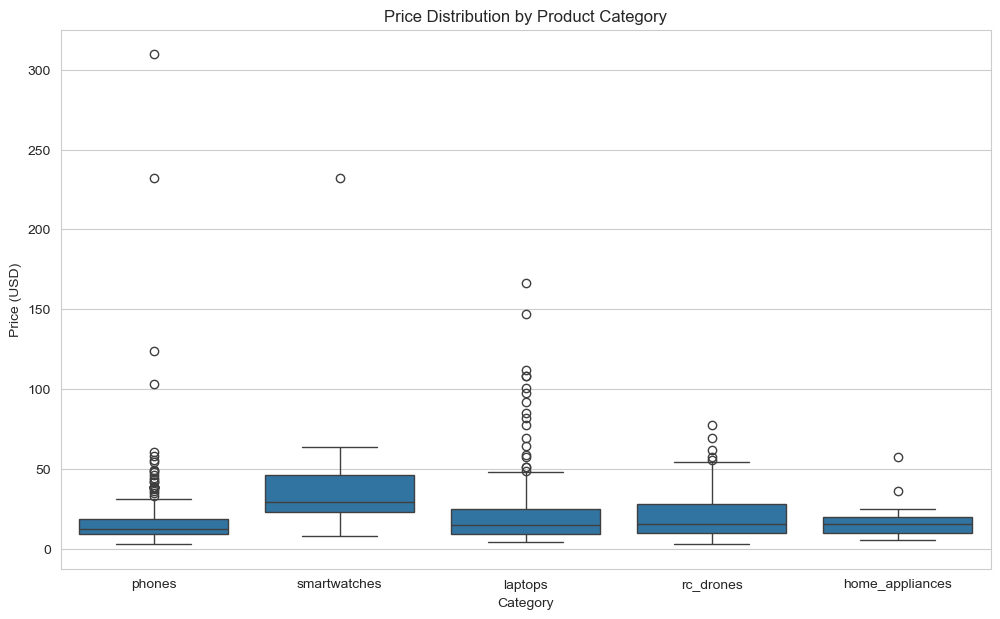


⭐ 2. Rating vs Price Correlation (Overall)
Overall Correlation between Price and Rating: -0.10


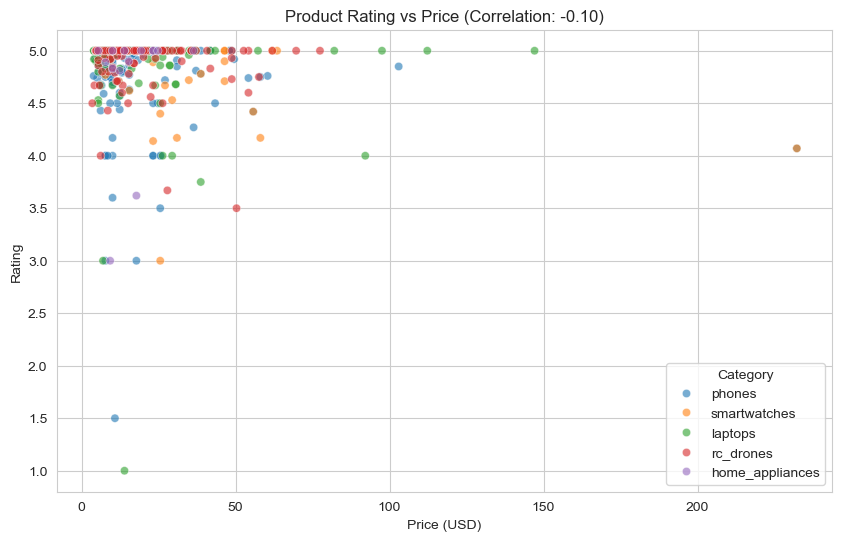

In [15]:
## Cell 3: Analysis 1 & 2 (Price Distribution & Rating Correlation)

print("\n--- Starting Exploratory Data Analysis (EDA) ---")
print("-" * 50)

# ---------------- 1. Price Distribution per Category (Box Plot) ----------------
print("\n⭐ 1. Price Distribution per Category")
plt.figure(figsize=(12, 7))
# Filter out zero prices for better visualization
sns.boxplot(x='category', y='price', data=all_data_combined[all_data_combined['price'] > 0])
plt.title('Price Distribution by Product Category')
plt.xlabel('Category')
plt.ylabel('Price (USD)')
plt.show()


# ---------------- 2. Rating vs Price Correlation (Scatter Plot) ----------------
print("\n⭐ 2. Rating vs Price Correlation (Overall)")
# Filter data for positive prices and ratings
filtered_data = all_data_combined[(all_data_combined['price'] > 0) & (all_data_combined['rating'] > 0)]

correlation = filtered_data['rating'].corr(filtered_data['price'])
print(f"Overall Correlation between Price and Rating: {correlation:.2f}")

plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='rating', hue='category', data=filtered_data, alpha=0.6)
plt.title(f'Product Rating vs Price (Correlation: {correlation:.2f})')
plt.xlabel('Price (USD)')
plt.ylabel('Rating')
plt.legend(title='Category')
plt.show()


⭐ 3. Top Reviewed Products (Overall)

Top 10 Products by Number of Reviews:
         category                                       product_name  reviews  \
89         phones  5.5 Inch Outdoor EDC Tactical Waist Bags Pack ...     1557   
26         phones  Blitzmax BM-TS4 3 in 1 Tablet/Phone Holder Por...     1262   
335       laptops  BlitzWolf® BW-WA4 30W Wireless Speaker Portabl...      969   
301  smartwatches  [World Premiere]Zeblaze GTR 3 Pro 1.43 inch Ul...      534   
300  smartwatches  [World Premiere]New Zeblaze GTS 3 Pro Ultra-bi...      500   
0          phones  [World Premiere]New Zeblaze GTS 3 Pro Ultra-bi...      500   
449       laptops  DANIU 3Pcs Metal Spudger Repair Opening Tool f...      388   
357       laptops  DC-DC 8.5-48V To 10-50V 10A 250W Continuous Ad...      374   
343       laptops  Dual Mode BT3.0/5.2 2.4G Wireless Mouse Adjust...      331   
5          phones  [2023 World Premiere]NEW Zeblaze GTS 3 Ultra-l...      291   

     rating  price  
89     4.9

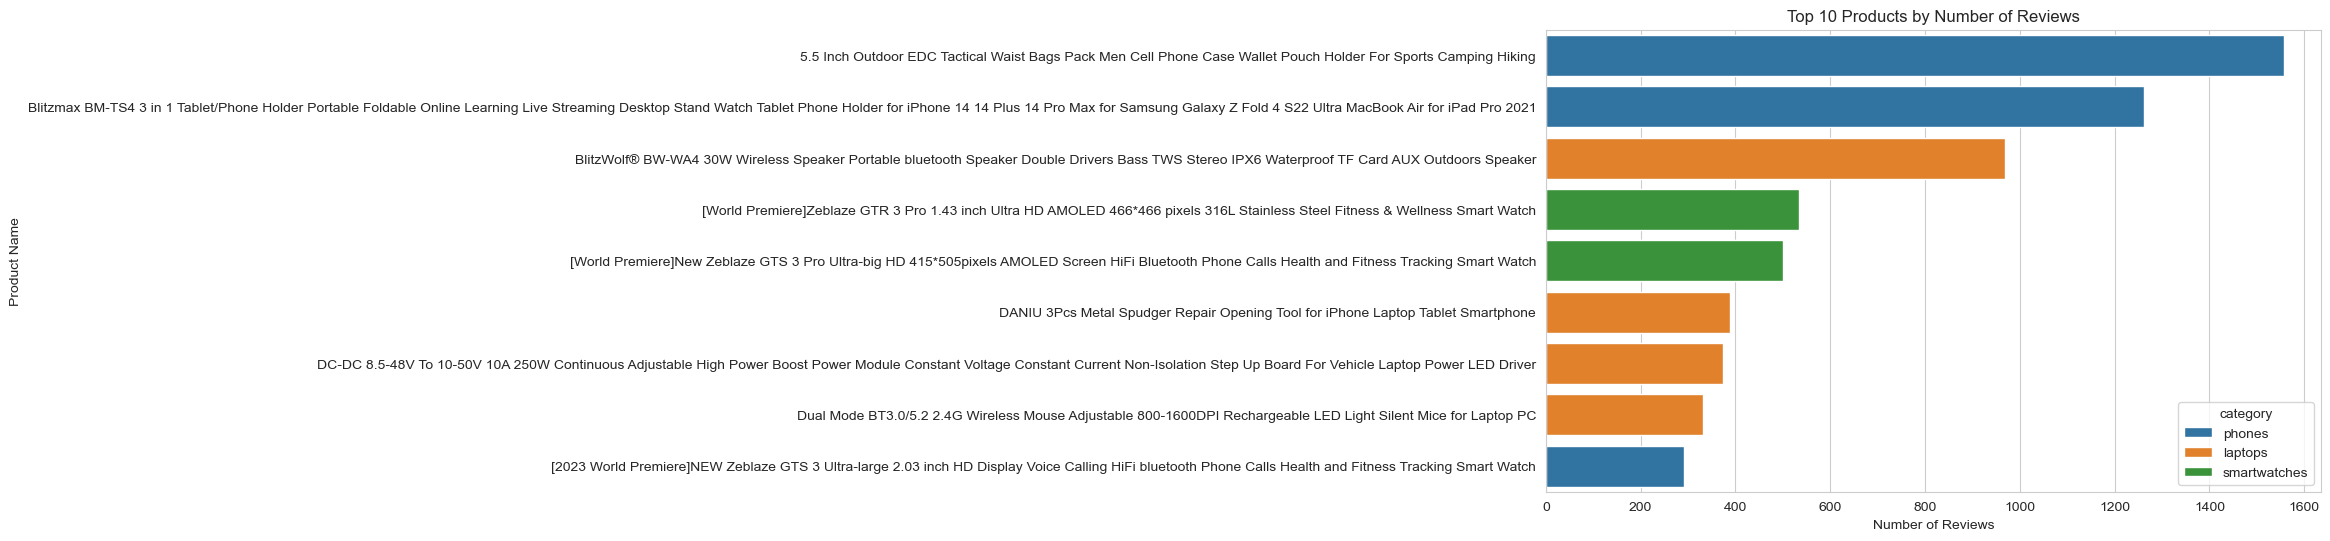


⭐ 4. Best Value Products per Category (Value = Rating / Price)

Top 3 Best Value Products per Category (Highest Rating/Price Score):
            category                                       product_name  \
59            phones  RC-190 60W Mini Data Cable Storage Kit Box Typ...   
89            phones  5.5 Inch Outdoor EDC Tactical Waist Bags Pack ...   
35            phones  Lenovo U3 High Speed TF Memory Card 32GB 64GB ...   
0       smartwatches  [World Premiere]New Zeblaze GTS 3 Pro Ultra-bi...   
2       smartwatches  [2023 World Premiere]NEW Zeblaze GTS 3 Ultra-l...   
4       smartwatches  [2024 World Premiere]NEW Zeblaze Btalk Plus Ul...   
145          laptops  USB3.2 20Gbps Type-C to Type-C Cable 5A 100W F...   
222          laptops  USB3.2 20Gbps Type-C to Type-C Cable 5A 100W F...   
17           laptops  Transparent LED Display 240W USB4.0 40Gbps Typ...   
30         rc_drones  4 Pairs Gemfan 1208 31mm 1.2 Inch 4-Blade Prop...   
31         rc_drones  2 / 6 Pairs Gemfan 

In [16]:
## Cell 4: Analysis 3 & 4 (Top Reviewed & Best Value)

# ---------------- 3. Top Reviewed Products (Most Popular) ----------------
print("\n⭐ 3. Top Reviewed Products (Overall)")
# Select top 10 products based on the number of reviews
top_reviewed = all_data_combined.sort_values(by='reviews', ascending=False).head(10)[
    ['category', 'product_name', 'reviews', 'rating', 'price']
]
print("\nTop 10 Products by Number of Reviews:")
print(top_reviewed)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='reviews', y='product_name', data=top_reviewed, hue='category', dodge=False)
plt.title('Top 10 Products by Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Product Name')
plt.show()


# ---------------- 4. Best Value Metric per Category (Rating / Price) ----------------
print("\n⭐ 4. Best Value Products per Category (Value = Rating / Price)")
results_df = pd.DataFrame()

for category, df in data_frames.items():
    # Calculate 'Value_Score' (High Rating / Low Price). Avoid division by zero.
    df['Value_Score'] = (df['rating'] / df['price']).replace([float('inf'), -float('inf')], 0).fillna(0)
    
    # Select top 3 "Best Value" products
    best_value_products = df.sort_values(by='Value_Score', ascending=False).head(3)
    
    # Append results
    results_df = pd.concat([results_df, best_value_products])

print("\nTop 3 Best Value Products per Category (Highest Rating/Price Score):")
print(results_df[['category', 'product_name', 'rating', 'price', 'Value_Score']])


⭐ 5. Average Discount Percentage by Category

Average Discount Percentage:
          category  discount_pct
0     smartwatches     49.531786
1           phones     35.712115
2          laptops     35.434481
3  home_appliances     33.355652
4        rc_drones     23.383778


C:\Users\Hp\AppData\Local\Temp\ipykernel_3260\563006567.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='discount_pct', data=avg_discount, palette='viridis')


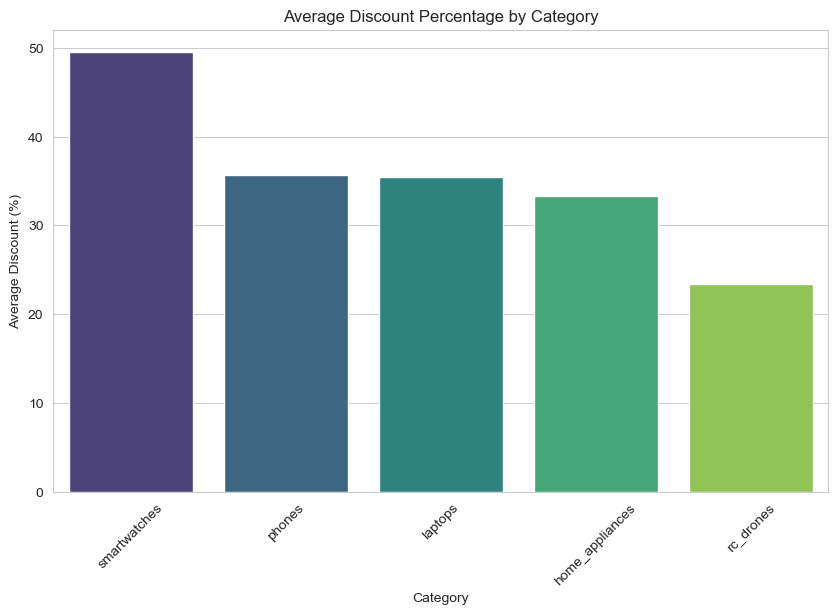


--- EDA Complete ---


In [17]:
## Cell 5: Analysis 5 (Discount Percentage Analysis) and Conclusion

# ---------------- 5. Discount Percentage Analysis ----------------
print("\n⭐ 5. Average Discount Percentage by Category")
# Filter products that had an old price (i.e., were discounted)
discount_data = all_data_combined[all_data_combined['old_price'] > 0]

# Calculate mean discount percentage by category
avg_discount = discount_data.groupby('category')['discount_pct'].mean().sort_values(ascending=False).reset_index()

print("\nAverage Discount Percentage:")
print(avg_discount)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='category', y='discount_pct', data=avg_discount, palette='viridis')
plt.title('Average Discount Percentage by Category')
plt.xlabel('Category')
plt.ylabel('Average Discount (%)')
plt.xticks(rotation=45)
plt.show()

print("\n--- EDA Complete ---")

In [25]:
import os
import pandas as pd
import re

# ---------------- CONFIGURATION ----------------
INPUT_DIR = "data/raw"
OUTPUT_DIR = "data/final_processed"
OUTPUT_FILE_NAME = "all_banggood_products_summary.csv"
CATEGORIES = ["phones", "smartwatches", "laptops", "rc_drones", "home_appliances"]

# ---------------- HELPER FUNCTIONS (Cleaning) ----------------
# NOTE: All cleaning functions are kept brief for a short code
def clean_price(price):
    if pd.isna(price): return 0.0
    try:
        return float(re.search(r"[\d.]+", str(price).replace(',', '')).group())
    except:
        return 0.0

def clean_reviews(reviews):
    if pd.isna(reviews): return 0
    try:
        return int(re.search(r"(\d+)", str(reviews).replace(',', '')).group(1))
    except:
        return 0

def clean_rating(rating):
    if pd.isna(rating): return 0.0
    try:
        return float(re.search(r"(\d+(\.\d+)?)", str(rating)).group(1))
    except:
        return 0.0

# ---------------- MAIN PROCESS (Load, Clean, Derive, Combine) ----------------
all_data_combined = pd.DataFrame()
print("Starting combined data processing...")

for category in CATEGORIES:
    file_path = os.path.join(INPUT_DIR, f"{category}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        
        # Cleaning
        df['price'] = df['price'].apply(clean_price)
        df['old_price'] = df['old_price'].apply(clean_price)
        df['reviews'] = df['reviews'].apply(clean_reviews)
        df['rating'] = df['rating'].apply(clean_rating)
        
        # Feature Engineering (Derive)
        df['price_drop'] = df['old_price'] - df['price']
        
        # Discount % calculation (avoiding division by zero)
        df['discount_pct'] = ((df['price_drop'] / df['old_price']) * 100).round(2).fillna(0)
        df.loc[df['old_price'] == 0, 'discount_pct'] = 0
        
        df['popularity_score'] = df['reviews'] * df['rating']
        
        # Combine
        all_data_combined = pd.concat([all_data_combined, df], ignore_index=True)
        print(f"Loaded and processed: {category}")
    else:
        print(f"Skipped: {file_path} not found.")

# ---------------- SAVE TO CSV ----------------

# Output directory banana
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PATH = os.path.join(OUTPUT_DIR, OUTPUT_FILE_NAME)

# Final columns set karna
final_columns = [
    'category', 'product_name', 'product_url', 'price', 'old_price', 
    'reviews', 'rating', 'price_drop', 'discount_pct', 'popularity_score'
]

# Data ko save karna
all_data_combined[final_columns].to_csv(OUTPUT_PATH, index=False, encoding='utf-8')

print("\n--- PROCESS COMPLETE ---")
print(f"Total Rows Saved: {len(all_data_combined)}")
print(f"✅ CSV file created at: {OUTPUT_PATH}")

Starting combined data processing...
Loaded and processed: phones
Loaded and processed: smartwatches
Loaded and processed: laptops
Loaded and processed: rc_drones
Loaded and processed: home_appliances

--- PROCESS COMPLETE ---
Total Rows Saved: 708
✅ CSV file created at: data/final_processed\all_banggood_products_summary.csv


In [28]:
import pyodbc
import pandas as pd
import os

# ---------------- CONNECTION DETAILS (Corrected) ----------------

# 1. SERVER NAME
SERVER_NAME = 'DESKTOP-VOJ4GS8' 

# 2. DATABASE NAME (Ye woh variable hai jo aapne define kiya hai)
DATABASE_NAME = 'TechDataAnalysis' # Assuming you've created this DB in SSMS

# 3. TABLE NAME
TABLE_NAME = 'Banggood_Products_Unified' 

# ---------------- CONNECTION STRING (Corrected f-string usage) ----------------

# Using Windows Authentication (Trusted_Connection=yes)
CONNECTION_STRING = (
    f'DRIVER={{ODBC Driver 17 for SQL Server}};'
    f'SERVER={SERVER_NAME};' 
    f'DATABASE={DATABASE_NAME};' # <<-- ERROR FIXED: Now using the correct variable
    r'Trusted_Connection=yes;'
)

# ---------------- VERIFICATION ----------------
# NOTE: 'DESKTOP-VOJ4GS8' ko bhi variable ke zariye print karna chahiye
print(f"Connection parameters set. SERVER: {SERVER_NAME}") 
print(CONNECTION_STRING)

Connection parameters set. SERVER: DESKTOP-VOJ4GS8
DRIVER={ODBC Driver 17 for SQL Server};SERVER=DESKTOP-VOJ4GS8;DATABASE=TechDataAnalysis;Trusted_Connection=yes;
